# Decision Tree

## Load Data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 100
d = 2
ranges = 2
postives = np.random.randn(n, d) + np.array([ranges, -ranges])
negatives = np.random.randn(n, d) + np.array([-ranges, ranges])

postives = np.round(postives)
negatives = np.round(negatives)

postives = np.column_stack((postives, np.ones(n)))
negatives = np.column_stack((negatives, np.zeros(n)))

def split_dataset(X,y, test_size = 0.2):
    '''
    Split the dataset into training and testing set.
    '''
    n = X.shape[0]
    n_test = int(n*test_size)
    n_train = n - n_test
    mask = np.random.permutation(n)
    X = X[mask]
    y = y[mask]
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]
    return X_train, X_test, y_train, y_test

data = np.vstack((postives, negatives))
np.random.shuffle(data)
X, y = data[:, :-1], data[:, -1]

# train_size = int(2*n*0.8)
# X_train = X[:train_size]
# y_train = y[:train_size]
# X_test = X[train_size:]
# y_test = y[train_size:]

X_train, X_test, y_train, y_test = split_dataset(X, y, 0.2)

print(f'{X_train.shape = }\n{X_test.shape = }\n{y_train.shape = }\n{y_test.shape = }\n')

X_train.shape = (160, 2)
X_test.shape = (40, 2)
y_train.shape = (160,)
y_test.shape = (40,)



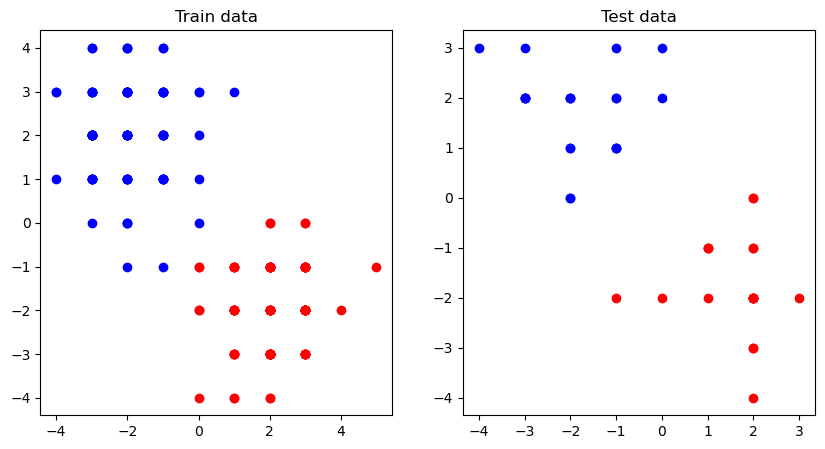

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
_ = axes[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red')
_ = axes[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue')
_ = axes[0].set_title('Train data')
_ = axes[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red')
_ = axes[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue')
_ = axes[1].set_title('Test data')


In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtree_builtin = DecisionTreeClassifier()
dtree_builtin.fit(X_train, y_train)

y_pred = dtree_builtin.predict(X_test) 
print(f'Acc : {accuracy_score(y_pred, y_test):.2%}')

DecisionTreeClassifier()

Acc : 97.50%


## Custom implementation to solve DTree

In [5]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

In [6]:

class DecisionTree_Classifier:
    def __init__(self, method = 'entropy', depth_threshold=None, min_samples_split=2):
        self.depth_threshold = depth_threshold or 1000
        self.min_samples_split = min_samples_split
        self.root = None
        self.method = method
        
    def _entropy(self, y):
        m = len(y)
        if m == 0:
            return 0
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / m
        log_probs = np.log(probs)
        p_log_p = probs * log_probs
        return -1 * np.sum(p_log_p)
    
    def _gini(self, y):
        m = len(y)
        if m == 0:
            return 0
        classes, counts = np.unique(y, return_counts=True)
        probs = counts / m
        return 1 - np.sum(probs ** 2)
    
    def _best_split(self, X, y):
        m, n = X.shape
        best_info_gain = float('-inf')
        best_idx, best_thr = None, None

        if m >= self.min_samples_split:
            for idx in range(n):
                all_y_vals = np.unique(X[:, idx])
                for yi in all_y_vals:
                    left_mask = X[:, idx] <= yi
                    right_mask = X[:, idx] > yi
                    if left_mask.sum() == 0 or right_mask.sum() == 0:
                        continue
                    if self.method == 'entropy':
                        info_gain_left = self._entropy(y[left_mask])
                        info_gain_right = self._entropy(y[right_mask])
                    elif self.method == 'gini':
                        info_gain_left = self._gini(y[left_mask])
                        info_gain_right = self._gini(y[right_mask])
                    
                    info_gain = -1 * (left_mask.sum() * info_gain_left + right_mask.sum() * info_gain_right) / m

                    if info_gain > best_info_gain:
                        best_info_gain = info_gain
                        best_idx = idx
                        best_thr = yi

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth):
        num_samples_per_class = [np.sum(y == c) for c in np.unique(y)]
        majority_class = np.unique(y)[np.argmax(num_samples_per_class)]
        
        if (depth >= self.depth_threshold or len(np.unique(y)) == 1 or len(y) < self.min_samples_split):
            return Node(value = majority_class)

        idx, thr = self._best_split(X, y)
        
        if idx is None:
            return Node(value = majority_class)

        left_mask = X[:, idx] <= thr
        right_mask =  X[:, idx] > thr
        left = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return Node(idx, thr, left, right)

    def _predict(self, inputs, node):
        if node.value is not None:
            return node.value
        if inputs[node.feature] <= node.threshold:
            return self._predict(inputs, node.left)
        return self._predict(inputs, node.right)
    
    def fit(self, X, y):
        self.root = self._grow_tree(X, y, depth=0)

    def predict(self, X):
        return np.array([self._predict(inputs, self.root) for inputs in X])

    def acc_score(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

    def plot(self, X_train, y_train, X_test = None, y_test = None):
        plt.figure(figsize=(10, 8))
        plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red' , alpha=0.5, label='Train -ve')
        plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue' , alpha=0.5 , label='Train +ve')

        if X_test is not None and y_test is not None:
            plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='red', marker='x' , alpha=0.9 , label='Test -ve')
            plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='blue', marker='x', alpha=0.9, label='Test +ve')

        plt.legend()
        plt.show()

### using entropy

In [7]:
dtree = DecisionTree_Classifier(
    depth_threshold = 5
    )
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test) 
print(f'\nAcc : {dtree.acc_score(y_pred, y_test):.2%}\n\n')


Acc : 97.50%




### using gini

In [8]:
dtree = DecisionTree_Classifier(
    method='gini',
    depth_threshold = 5,
    )
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test) 
print(f'\nAcc : {dtree.acc_score(y_pred, y_test):.2%}\n\n')


Acc : 97.50%




## Hyperparameter finding

In [9]:
X_train_2, X_val, y_train_2, y_val = split_dataset(X_train, y_train, 0.4)

print(f'{X_train_2.shape = }\n{X_val.shape = }\n{y_train_2.shape = }\n{y_val.shape = }\n')

X_train_2.shape = (96, 2)
X_val.shape = (64, 2)
y_train_2.shape = (96,)
y_val.shape = (64,)



In [10]:
accs = []
for depth in range(1,11):
    dtree = DecisionTree_Classifier(
        method='gini',
        depth_threshold = depth
    )
    dtree.fit(X_train_2, y_train_2)

    y_pred_2 = dtree.predict(X_val) 
    acc_i = dtree.acc_score(y_pred_2, y_val)
    # print(f'\nAcc : {acc_i:.2%}\n\n')
    accs.append(acc_i)
accs = np.array(accs)
accs

array([0.96875 , 0.984375, 0.984375, 0.984375, 0.984375, 0.984375,
       0.984375, 0.984375, 0.984375, 0.984375])

In [11]:
acc_max = np.argmax(accs)
acc_max, accs[acc_max]

(1, 0.984375)

In [12]:
dtree = DecisionTree_Classifier(
    method='gini',
    depth_threshold = acc_max,
    )
dtree.fit(X_train, y_train)

y_pred = dtree.predict(X_test) 
print(f'\nAcc : {dtree.acc_score(y_pred, y_test):.2%}\n\n')


Acc : 92.50%




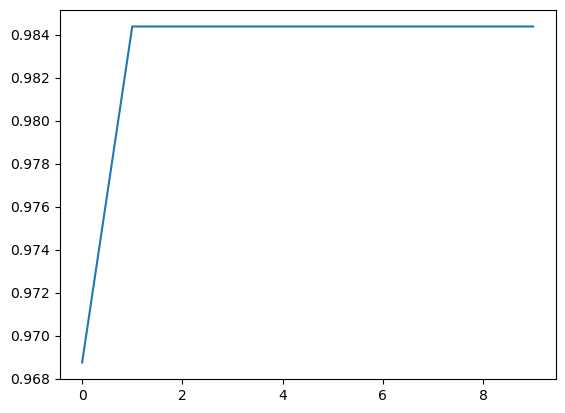

In [13]:
plt.plot(accs)

### Aci IMDB Dataset

In [14]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import time 
DataFolder = './data/aclImdb/'
X_train = np.load(DataFolder + 'X_train.npy') 
y_train = np.load(DataFolder + 'y_train.npy')
X_train.shape , y_train.shape

((25000, 100), (25000,))

In [15]:
X_test = np.load(DataFolder + 'X_test.npy')
y_test = np.load(DataFolder + 'y_test.npy')
X_test.shape , y_test.shape

((25000, 100), (25000,))

In [16]:
dtree = DecisionTree_Classifier(
    method='gini',
    depth_threshold = 5,
    )

dtree.fit(X_train, y_train)

In [17]:
y_pred = dtree.predict(X_test) 
print(f'\nAcc : {dtree.acc_score(y_pred, y_test):.2%}\n\n')


Acc : 60.81%


